# Data Loading & Exploratory Data Analysis (EDA)

## Overview
This notebook covers the **first phase** of our systemic cyber risk analysis workflow:

### Objectives
1. **Load** the raw vulnerability dataset into a pandas `DataFrame`
2. **Inspect** basic characteristics – column names, shape, and data types
3. **Assess** missing‐value patterns and categorical distributions to inform later cleaning
4. **Visualize** trends over time (e.g., CVEs per year) to detect obvious anomalies or biases
5. **Filter** data to focus on relevant time periods and vulnerability versions
6. **Create target variable** by merging with known exploited vulnerabilities

### Rationale
A thorough exploratory data analysis is crucial for several reasons:
- **Data Validation**: Ensures the input data matches our expectations and requirements
- **Quality Assessment**: Surfaces data quality issues early, saving time in downstream processing
- **Feature Understanding**: Provides insights into the distribution and characteristics of each feature
- **Target Definition**: Establishes the ground truth for our machine learning models
- **Temporal Analysis**: Identifies trends and patterns that may influence modeling decisions

### Expected Outcomes
By the end of this notebook, we will have:
- A clean, filtered dataset focused on CVEs from 2016 onwards
- A clear understanding of data quality and missing value patterns
- A binary target variable indicating known exploited vulnerabilities
- Saved processed data for use in subsequent notebooks


In [53]:
# Import required libraries for data analysis and visualization
import pandas as pd                    # For data manipulation and analysis
import numpy as np                     # For numerical operations
import matplotlib.pyplot as plt        # For creating static visualizations
import seaborn as sns                  # For statistical data visualization
import warnings                        # For controlling warning messages
from pathlib import Path               # For robust file path handling

# Configure display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns when displaying DataFrames
pd.set_option('display.width', None)        # Remove width restrictions
pd.set_option('display.max_colwidth', 50)   # Limit column width for readability

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


## 1. Data Loading

In this section, we load the vulnerability dataset and perform initial inspection. The dataset contains Common Vulnerabilities and Exposures (CVE) records with various scoring metrics and categorical features.

### Data Source
- **File**: `data/vulnerabilities.csv` located in the data directory (created by running the merge_files.py in /modeling)
- **Content**: CVE records with CVSS scores, impact assessments, and metadata
- **Purpose**: Train machine learning models to predict vulnerability exploitability


In [ ]:
# Load the vulnerability dataset from CSV file
# low_memory=False ensures consistent data types across all rows
df = pd.read_csv('../../data/vulnerabilities.csv', low_memory=False)

# Display basic information about the dataset
print("📊 Dataset Overview:")
print(f"Shape: {df.shape}")  # Show number of rows and columns
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")  # Calculate memory usage

# Show the first few rows to understand data structure
print("\n🔍 First 5 rows:")
df.head()

📊 Dataset Overview:
Shape: (404790, 54)
Memory usage: 797.24 MB

🔍 First 5 rows:


,Unnamed: 0,id,baseScoreAv,exploitScoreAv,impactScoreAv,baseScoreMax,exploitScoreMax,impactScoreMax,version,vectorString,baseSeverity,attackVector,attackComplexity,privilegesRequired,userInteractions,scope,confidentialityImpact,integrityImpact,availabilityImpact,numScores,agreement,accessVector,accessComplexity,authentication,userInteraction,description,attackRequirements,vulnConfidentialityImpact,vulnIntegrityImpact,vulnAvailabilityImpact,subConfidentialityImpact,subIntegrityImpact,subAvailabilityImpact,exploitMaturity,confidentialityRequirement,integrityRequirement,availabilityRequirement,modifiedAttackVector,modifiedAttackComplexity,modifiedAttackRequirements,modifiedPrivilegesRequired,modifiedUserInteraction,modifiedVulnConfidentialityImpact,modifiedVulnIntegrityImpact,modifiedVulnAvailabilityImpact,modifiedSubConfidentialityImpact,modifiedSubIntegrityImpact,modifiedSubAvailabilityImpact,Safety,Automatable,Recovery,valueDensity,vulnerabilityResponseEffort,providerUrgency
0,0,CVE-1999-0217,5.0,10.0,2.9,5.0,10.0,2.9,2.0,AV:N/AC:L/Au:N/C:N/I:N/A:P,NaN,NaN,NaN,NaN,NaN,NaN,NONE,NONE,PARTIAL,1,0,NETWORK,LOW,NONE,NaN,Malicious option settings in UDP packets could...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CVE-1999-0702,10.0,10.0,10.0,10.0,10.0,10.0,2.0,AV:N/AC:L/Au:N/C:C/I:C/A:C,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE,COMPLETE,COMPLETE,1,0,NETWORK,LOW,NONE,NaN,Internet Explorer 5.0 and 5.01 allows remote a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,CVE-1999-0352,7.2,3.9,10.0,7.2,3.9,10.0,2.0,AV:L/AC:L/Au:N/C:C/I:C/A:C,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE,COMPLETE,COMPLETE,1,0,LOCAL,LOW,NONE,NaN,ControlIT 4.5 and earlier (aka Remotely Possib...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,CVE-1999-0978,7.5,10.0,6.4,7.5,10.0,6.4,2.0,AV:N/AC:L/Au:N/C:P/I:P/A:P,NaN,NaN,NaN,NaN,NaN,NaN,PARTIAL,PARTIAL,PARTIAL,1,0,NETWORK,LOW,NONE,NaN,htdig allows remote attackers to execute comma...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,CVE-1999-0581,10.0,10.0,10.0,10.0,10.0,10.0,2.0,AV:N/AC:L/Au:N/C:C/I:C/A:C,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE,COMPLETE,COMPLETE,1,0,NETWORK,LOW,NONE,NaN,The HKEY_CLASSES_ROOT key in a Windows NT syst...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Initial Data Cleaning

### Column Removal Strategy
We remove columns that are:
- **Redundant**: Unnamed index columns or duplicate information
- **Too Granular**: Overly specific features that may cause overfitting
- **Inconsistent**: Columns with poor data quality or sparse information
- **Text-based**: Raw descriptions that require specialized NLP processing

This initial pruning focuses our analysis on the most relevant and reliable features for predicting vulnerability exploitation.


In [ ]:
# Define columns to remove based on data quality and relevance analysis
columns_to_remove = [
    # Index and metadata columns
    'Unnamed: 0',                              # Redundant index column
    'vectorString',                            # Raw vector string (we have parsed components)
    'description',                             # Text field requiring NLP processing
    
    # Legacy/deprecated CVSS fields (often sparse or inconsistent)
    'userInteractions',                        # Deprecated field
    'accessVector',                            # Old CVSS v2 field
    'accessComplexity',                        # Old CVSS v2 field  
    'authentication',                          # Old CVSS v2 field
    
    # Environmental and temporal scoring (often missing/subjective)
    'attackRequirements',                      # Subjective assessment
    'exploitMaturity',                         # Temporal metric, often missing
    'confidentialityRequirement',              # Environmental metric
    'integrityRequirement',                    # Environmental metric
    'availabilityRequirement',                 # Environmental metric
    
    # Modified/adjusted scores (environmental, often not available)
    'modifiedAttackVector',                    # Environmental adjustment
    'modifiedAttackComplexity',                # Environmental adjustment
    'modifiedAttackRequirements',              # Environmental adjustment
    'modifiedPrivilegesRequired',              # Environmental adjustment
    'modifiedUserInteraction',                 # Environmental adjustment
    'modifiedVulnConfidentialityImpact',       # Environmental adjustment
    'modifiedVulnIntegrityImpact',             # Environmental adjustment
    'modifiedVulnAvailabilityImpact',          # Environmental adjustment
    'modifiedSubConfidentialityImpact',        # Environmental adjustment
    'modifiedSubIntegrityImpact',              # Environmental adjustment
    'modifiedSubAvailabilityImpact',           # Environmental adjustment
    
    # Detailed impact subcategories (redundant with main impact scores)
    'vulnConfidentialityImpact',               # Covered by confidentialityImpact
    'vulnIntegrityImpact',                     # Covered by integrityImpact
    'vulnAvailabilityImpact',                  # Covered by availabilityImpact
    'subConfidentialityImpact',                # Subsequent system impacts
    'subIntegrityImpact',                      # Subsequent system impacts
    'subAvailabilityImpact',                   # Subsequent system impacts
    
    # Specialized assessment categories (often sparse)
    'Safety',                                  # Safety impact assessment
    'Automatable',                             # Automation potential
    'Recovery',                                # Recovery difficulty
    'valueDensity',                            # Value density assessment
    'vulnerabilityResponseEffort',             # Response effort estimate
    'providerUrgency',                         # Provider urgency rating
    'description'                              # Description of the vulnerability
]

# Remove the specified columns and show the impact
print(f"📊 Original dataset shape: {df.shape}")
df = df.drop(columns=columns_to_remove)
print(f"📊 After column removal: {df.shape}")
print(f"🗑️ Removed {len(columns_to_remove)} columns")

# Display remaining columns for verification
print(f"\n📋 Remaining columns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")
    
print("\n✅ Column removal completed successfully!")



📊 Original dataset shape: (404790, 54)
📊 After column removal: (404790, 19)
🗑️ Removed 35 columns

📋 Remaining columns (19):
 1. id
 2. baseScoreAv
 3. exploitScoreAv
 4. impactScoreAv
 5. baseScoreMax
 6. exploitScoreMax
 7. impactScoreMax
 8. version
 9. baseSeverity
10. attackVector
11. attackComplexity
12. privilegesRequired
13. scope
14. confidentialityImpact
15. integrityImpact
16. availabilityImpact
17. numScores
18. agreement
19. userInteraction

✅ Column removal completed successfully!


## 3. Version Filtering and Deduplication

### CVSS Version Considerations
Different CVSS versions use different scoring methodologies:
- **CVSS v2**: Older scoring system with different metrics
- **CVSS v3+**: Modern scoring with improved accuracy and consistency

We focus on CVSS v3+ data for several reasons:
- More consistent and reliable scoring methodology
- Better alignment with modern threat landscape
- Improved accuracy in risk assessment

### Deduplication Strategy
Each CVE should appear only once in our dataset to avoid:
- Biased model training from duplicate records
- Inflated performance metrics
- Inconsistent feature relationships


In [56]:
# Analyze CVSS version distribution before filtering
print("📊 CVSS Version Distribution (before filtering):")
version_counts = df['version'].value_counts().sort_index()
for version, count in version_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  Version {version}: {count:,} records ({percentage:.1f}%)")

# Filter out CVSS version 4.0 (likely erroneous or very recent/experimental)
# Version 4.0 may have inconsistent scoring or be a data entry error
print(f"\n🔄 Filtering out version 4.0...")
df_before_version_filter = df.copy()  # Keep backup for comparison
df = df[df['version'] != 4.0].copy()  # Remove version 4.0 records

print(f"📊 Records removed due to version filter: {len(df_before_version_filter) - len(df):,}")

# Remove duplicate CVE IDs, keeping the first occurrence
# This ensures each vulnerability is represented only once in our dataset
print(f"\n🔄 Removing duplicate CVE IDs...")
df_before_dedup = df.copy()  # Keep backup for comparison
duplicates_count = df.duplicated(subset=['id']).sum()
print(f"📊 Duplicate CVE IDs found: {duplicates_count:,}")

df = df.drop_duplicates(subset=['id'], keep='first')  # Keep first occurrence of each CVE
print(f"📊 Records after deduplication: {len(df):,}")

# Verify the filtering results
print(f"\n✅ Version filtering and deduplication summary:")
print(f"  Original records: {len(df_before_version_filter):,}")
print(f"  After version filtering: {len(df_before_dedup):,}")
print(f"  After deduplication: {len(df):,}")
print(f"  Total records removed: {len(df_before_version_filter) - len(df):,}")
print(f"  Data retention rate: {(len(df) / len(df_before_version_filter)) * 100:.1f}%")

📊 CVSS Version Distribution (before filtering):
  Version 2.0: 186,366 records (46.0%)
  Version 3.0: 53,460 records (13.2%)
  Version 3.1: 158,573 records (39.2%)
  Version 4.0: 6,391 records (1.6%)

🔄 Filtering out version 4.0...
📊 Records removed due to version filter: 6,391

🔄 Removing duplicate CVE IDs...
📊 Duplicate CVE IDs found: 124,337
📊 Records after deduplication: 274,062

✅ Version filtering and deduplication summary:
  Original records: 404,790
  After version filtering: 398,399
  After deduplication: 274,062
  Total records removed: 130,728
  Data retention rate: 67.7%


In [57]:
# Display final CVSS version distribution after filtering
print("📊 CVSS Version Distribution (after filtering):")
version_counts_final = df['version'].value_counts().sort_index()
for version, count in version_counts_final.items():
    percentage = (count / len(df)) * 100
    print(f"  Version {version}: {count:,} records ({percentage:.1f}%)")

# Show the actual distribution as a pandas Series for detailed analysis
print(f"\n📋 Detailed version breakdown:")
version_counts_final

📊 CVSS Version Distribution (after filtering):
  Version 2.0: 72,489 records (26.4%)
  Version 3.0: 43,000 records (15.7%)
  Version 3.1: 158,573 records (57.9%)

📋 Detailed version breakdown:


version
2.0     72489
3.0     43000
3.1    158573
Name: count, dtype: int64

## 4. Target Variable Creation

### Known Exploited Vulnerabilities (KEV)
Our target variable is based on the **CISA Known Exploited Vulnerabilities Catalog**, which represents:
- Vulnerabilities that have been observed being exploited in the wild
- High-priority threats that pose significant risk to organizations
- Ground truth labels for our machine learning models

### Binary Classification Problem
- **Target = 1**: CVE is listed in the Known Exploited Vulnerabilities catalog (exploited)
- **Target = 0**: CVE is not listed in the KEV catalog (not known to be exploited)

This creates a supervised learning problem where we predict the likelihood of a vulnerability being exploited based on its technical characteristics.


In [58]:
# Load the Known Exploited Vulnerabilities (KEV) catalog from CISA
# This file contains CVE IDs that have been observed being exploited in the wild
print("📂 Loading Known Exploited Vulnerabilities catalog...")
dt = pd.read_csv('../../data/known_exploited_vulnerabilities.csv')

# Display basic information about the KEV catalog
print(f"📊 KEV Catalog Overview:")
print(f"  Total known exploited CVEs: {len(dt):,}")
print(f"  KEV catalog columns: {list(dt.columns)}")

# Show a sample of the KEV data to understand its structure
print(f"\n🔍 Sample KEV records:")
print(dt.head())

# Create binary target variable by checking if each CVE is in the KEV catalog
# This creates our ground truth labels for supervised learning
print(f"\n🎯 Creating target variable...")
print("   Target = 1: CVE is in Known Exploited Vulnerabilities catalog")
print("   Target = 0: CVE is not in Known Exploited Vulnerabilities catalog")

# Convert KEV catalog to set for faster lookup (O(1) vs O(n) for list lookup)
kev_set = set(dt['cveID'].values)
df['target'] = df['id'].apply(lambda x: 1 if x in kev_set else 0)

# Calculate and display target variable statistics
exploit_count = df['target'].sum()
total_count = len(df)
exploit_rate = (exploit_count / total_count) * 100

print(f"\n📊 Target Variable Statistics:")
print(f"  Total CVEs in dataset: {total_count:,}")
print(f"  Known exploited CVEs: {exploit_count:,} ({exploit_rate:.2f}%)")
print(f"  Not known exploited: {total_count - exploit_count:,} ({100 - exploit_rate:.2f}%)")
print(f"  Class imbalance ratio: {(total_count - exploit_count) / exploit_count:.1f}:1")

print("\n✅ Target variable created successfully!")


📂 Loading Known Exploited Vulnerabilities catalog...
📊 KEV Catalog Overview:
  Total known exploited CVEs: 1,331
  KEV catalog columns: ['cveID', 'vendorProject', 'product', 'vulnerabilityName', 'dateAdded', 'shortDescription', 'requiredAction', 'dueDate', 'knownRansomwareCampaignUse', 'notes', 'cwes']

🔍 Sample KEV records:
            cveID vendorProject            product  \
0  CVE-2025-34028     Commvault     Command Center   
1  CVE-2024-58136  Yiiframework                Yii   
2  CVE-2024-38475        Apache        HTTP Server   
3  CVE-2023-44221     SonicWall  SMA100 Appliances   
4  CVE-2025-31324           SAP          NetWeaver   

                                   vulnerabilityName   dateAdded  \
0  Commvault Command Center Path Traversal Vulner...  2025-05-02   
1  Yiiframework Yii Improper Protection of Altern...  2025-05-02   
2  Apache HTTP Server Improper Escaping of Output...  2025-05-01   
3  SonicWall SMA100 Appliances OS Command Injecti...  2025-05-01   
4  SAP N

In [59]:
# Display detailed target distribution for verification
print("📊 Target Variable Distribution:")
target_counts = df['target'].value_counts().sort_index()
print(f"  Not Exploited (0): {target_counts[0]:,} records")
print(f"  Exploited (1): {target_counts[1]:,} records")

# Calculate additional statistics
total = target_counts.sum()
class_ratio = target_counts[0] / target_counts[1]
minority_percentage = (target_counts[1] / total) * 100

print(f"\n📈 Class Balance Analysis:")
print(f"  Majority class size: {target_counts[0]:,} ({100 - minority_percentage:.2f}%)")
print(f"  Minority class size: {target_counts[1]:,} ({minority_percentage:.2f}%)")
print(f"  Imbalance ratio: {class_ratio:.1f}:1")

# Return the value counts for detailed inspection
print(f"\n📋 Detailed breakdown:")
target_counts

📊 Target Variable Distribution:
  Not Exploited (0): 272,732 records
  Exploited (1): 1,330 records

📈 Class Balance Analysis:
  Majority class size: 272,732 (99.51%)
  Minority class size: 1,330 (0.49%)
  Imbalance ratio: 205.1:1

📋 Detailed breakdown:


target
0    272732
1      1330
Name: count, dtype: int64

## 5. Data Quality Assessment

### Missing Value Analysis
Understanding missing data patterns is crucial for:
- **Data Quality**: Identifying potential data collection issues
- **Feature Selection**: Determining which features are reliable for modeling
- **Preprocessing Strategy**: Planning appropriate imputation or handling methods
- **Bias Detection**: Recognizing if missing data introduces systematic bias

We'll analyze both the overall missing data patterns and temporal trends to understand how data completeness varies over time.


In [60]:
# Comprehensive missing value analysis
print("🔍 Missing Value Analysis")
print("=" * 50)

# Calculate missing values for each column
missing_values = df.isnull().sum()
total_rows = len(df)

# Create a detailed missing value report
missing_report = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': (missing_values.values / total_rows) * 100
}).sort_values('Missing_Count', ascending=False)

# Display columns with missing values
columns_with_missing = missing_report[missing_report['Missing_Count'] > 0]

if len(columns_with_missing) > 0:
    print(f"📊 Found {len(columns_with_missing)} columns with missing values:")
    print()
    for _, row in columns_with_missing.iterrows():
        print(f"  {row['Column']:<25} : {row['Missing_Count']:>6,} missing ({row['Missing_Percentage']:>5.1f}%)")
    
    # Identify columns with high missing percentages
    high_missing = columns_with_missing[columns_with_missing['Missing_Percentage'] > 50]
    if len(high_missing) > 0:
        print(f"\n⚠️  Columns with >50% missing data:")
        for _, row in high_missing.iterrows():
            print(f"  {row['Column']}: {row['Missing_Percentage']:.1f}% missing")
else:
    print("✅ No missing values found in any column!")

# Calculate overall data completeness
total_cells = df.shape[0] * df.shape[1]
missing_cells = missing_values.sum()
completeness_rate = ((total_cells - missing_cells) / total_cells) * 100

print(f"\n📈 Overall Data Completeness:")
print(f"  Total data points: {total_cells:,}")
print(f"  Missing data points: {missing_cells:,}")
print(f"  Data completeness: {completeness_rate:.2f}%")

# Return the detailed missing values summary
print(f"\n📋 Detailed missing value breakdown:")
missing_values

🔍 Missing Value Analysis
📊 Found 6 columns with missing values:

  attackComplexity          : 72,489 missing ( 26.4%)
  privilegesRequired        : 72,489 missing ( 26.4%)
  userInteraction           : 72,489 missing ( 26.4%)
  baseSeverity              : 72,489 missing ( 26.4%)
  attackVector              : 72,489 missing ( 26.4%)
  scope                     : 72,489 missing ( 26.4%)

📈 Overall Data Completeness:
  Total data points: 5,481,240
  Missing data points: 434,934
  Data completeness: 92.07%

📋 Detailed missing value breakdown:


id                           0
baseScoreAv                  0
exploitScoreAv               0
impactScoreAv                0
baseScoreMax                 0
exploitScoreMax              0
impactScoreMax               0
version                      0
baseSeverity             72489
attackVector             72489
attackComplexity         72489
privilegesRequired       72489
scope                    72489
confidentialityImpact        0
integrityImpact              0
availabilityImpact           0
numScores                    0
agreement                    0
userInteraction          72489
target                       0
dtype: int64

## 6. Temporal Data Quality Analysis

### Year-based Missing Value Patterns
Understanding how data quality varies over time helps us:
- **Identify Data Collection Changes**: CVSS methodologies and data collection practices evolve
- **Assess Temporal Bias**: Earlier years may have incomplete or inconsistent data
- **Guide Filtering Decisions**: Determine appropriate time windows for analysis
- **Understand Data Evolution**: See how vulnerability reporting has changed over time

The heatmap below visualizes missing data patterns across years, helping us identify periods with poor data quality.


📅 Extracting year information from CVE IDs...
📊 Year range in dataset: 1999 to 2025
📊 Total years covered: 27 years

🔍 Analyzing missing value patterns by year...
📊 Temporal missing data summary:
  Years analyzed: 27 years
  Columns analyzed: 20 columns


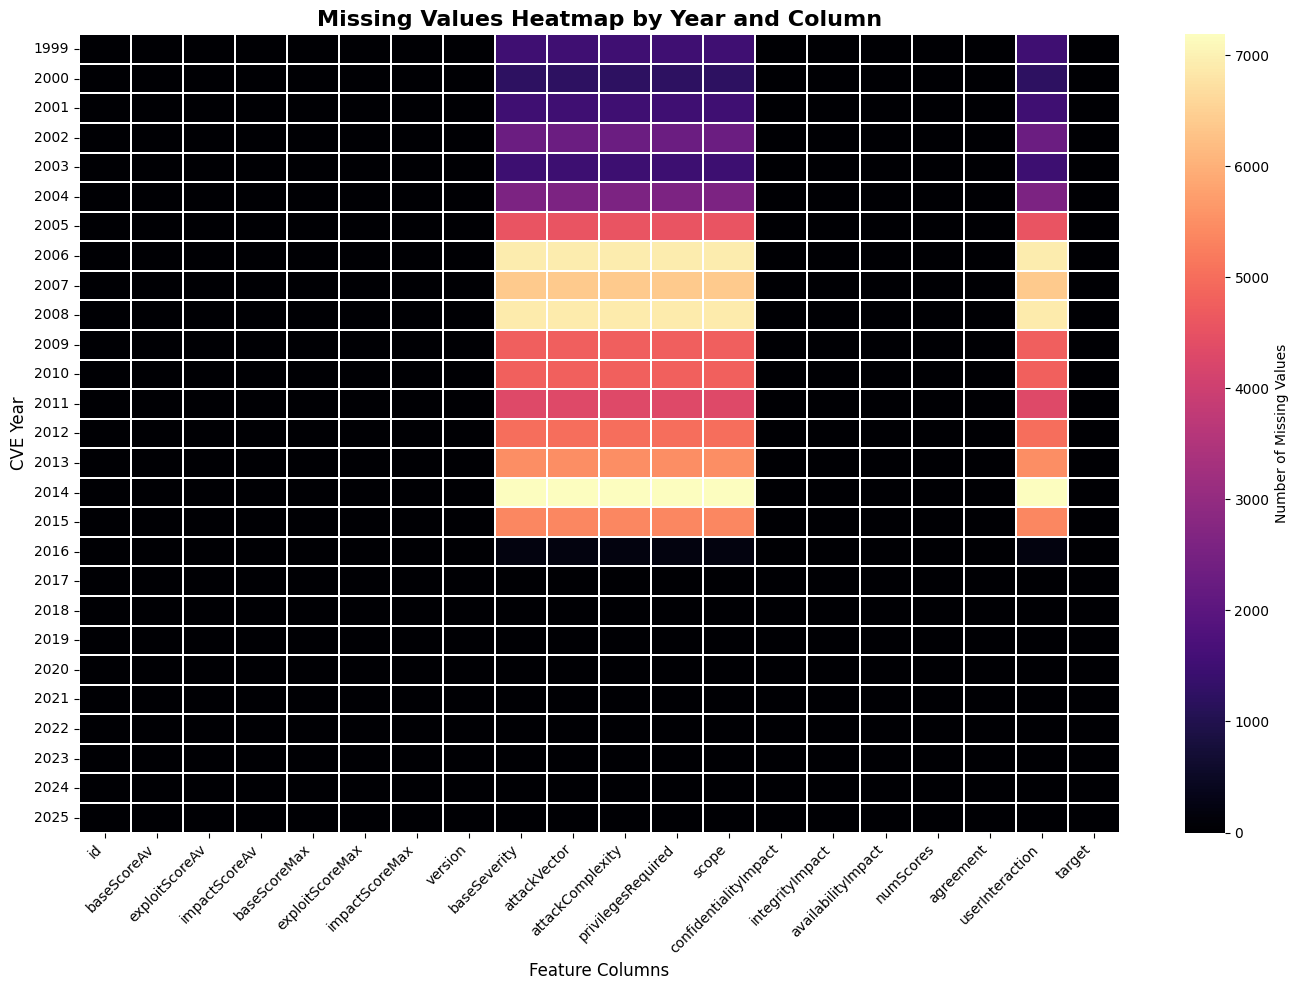


📊 Years with most missing data:
  2014: 43,128 missing values (25.6% of year's data)
  2006: 41,556 missing values (29.7% of year's data)
  2008: 41,412 missing values (29.6% of year's data)
  2007: 38,244 missing values (29.7% of year's data)
  2013: 33,006 missing values (26.7% of year's data)


In [61]:
# Extract year from CVE ID for temporal analysis
# CVE IDs follow the format: CVE-YYYY-NNNNN where YYYY is the year
print("📅 Extracting year information from CVE IDs...")
df['year'] = df['id'].str.extract(r'CVE-(\d{4})-')[0].astype(int)

# Validate year extraction
year_range = (df['year'].min(), df['year'].max())
print(f"📊 Year range in dataset: {year_range[0]} to {year_range[1]}")
print(f"📊 Total years covered: {year_range[1] - year_range[0] + 1} years")

# Calculate missing values by year for each column
# Use include_groups=False to avoid deprecation warning
print(f"\n🔍 Analyzing missing value patterns by year...")
null_counts_by_year = df.groupby('year', group_keys=False).apply(
    lambda x: x.isnull().sum(), 
    include_groups=False
)

# Display summary statistics about missing data patterns
print(f"📊 Temporal missing data summary:")
print(f"  Years analyzed: {len(null_counts_by_year)} years")
print(f"  Columns analyzed: {len(null_counts_by_year.columns)} columns")

# Create an enhanced heatmap of missing values by year
plt.figure(figsize=(14, 10))

# Create the heatmap with better styling
sns.heatmap(
    null_counts_by_year, 
    cmap='magma',               # Dark theme showing intensity
    cbar_kws={'label': 'Number of Missing Values'},  # Color bar label
    linewidths=0.1,             # Add subtle grid lines
    linecolor='white'           # Grid line color
)

# Enhance the plot formatting
plt.title('Missing Values Heatmap by Year and Column', fontsize=16, fontweight='bold')
plt.xlabel('Feature Columns', fontsize=12)
plt.ylabel('CVE Year', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate column names for readability
plt.yticks(rotation=0)               # Keep years horizontal
plt.tight_layout()                   # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

# Display years with highest missing data
total_missing_by_year = null_counts_by_year.sum(axis=1).sort_values(ascending=False)
print(f"\n📊 Years with most missing data:")
for year, missing_count in total_missing_by_year.head(5).items():
    total_possible = len(null_counts_by_year.columns)
    percentage = (missing_count / (total_possible * df[df['year'] == year].shape[0])) * 100
    print(f"  {year}: {missing_count:,} missing values ({percentage:.1f}% of year's data)")

In [62]:
# Display the detailed null counts by year matrix
print("📊 Detailed Missing Value Matrix by Year:")
print("Rows = Years, Columns = Features, Values = Number of Missing Entries")
print("=" * 80)

# Show the matrix with proper formatting
null_counts_by_year

📊 Detailed Missing Value Matrix by Year:
Rows = Years, Columns = Features, Values = Number of Missing Entries


,id,baseScoreAv,exploitScoreAv,impactScoreAv,baseScoreMax,exploitScoreMax,impactScoreMax,version,baseSeverity,attackVector,attackComplexity,privilegesRequired,scope,confidentialityImpact,integrityImpact,availabilityImpact,numScores,agreement,userInteraction,target
year,,,,,,,,,,,,,,,,,,,,
1999,0,0,0,0,0,0,0,0,1513,1513,1513,1513,1513,0,0,0,0,0,1513,0
2000,0,0,0,0,0,0,0,0,1223,1223,1223,1223,1223,0,0,0,0,0,1223,0
2001,0,0,0,0,0,0,0,0,1501,1501,1501,1501,1501,0,0,0,0,0,1501,0
2002,0,0,0,0,0,0,0,0,2296,2296,2296,2296,2296,0,0,0,0,0,2296,0
2003,0,0,0,0,0,0,0,0,1479,1479,1479,1479,1479,0,0,0,0,0,1479,0
2004,0,0,0,0,0,0,0,0,2599,2599,2599,2599,2599,0,0,0,0,0,2599,0
2005,0,0,0,0,0,0,0,0,4551,4551,4551,4551,4551,0,0,0,0,0,4551,0
2006,0,0,0,0,0,0,0,0,6926,6926,6926,6926,6926,0,0,0,0,0,6926,0
2007,0,0,0,0,0,0,0,0,6374,6374,6374,6374,6374,0,0,0,0,0,6374,0


## 7. Temporal Volume Analysis

### CVE Publication Trends
Analyzing the volume of vulnerabilities published each year reveals:
- **Security Landscape Evolution**: How cyber threats have grown over time
- **Reporting Maturity**: Improvements in vulnerability discovery and disclosure
- **Dataset Completeness**: Whether recent years have sufficient data for modeling
- **Historical Context**: Understanding the baseline rate of vulnerability discovery

This temporal analysis helps us make informed decisions about which time periods to include in our modeling.


📊 Analyzing CVE publication volume by year...

📈 CVE Volume Statistics:
  Total years: 27
  Average CVEs per year: 10150
  Peak year: 2024 (35,774 CVEs)
  Low year: 2000 (1,236 CVEs)


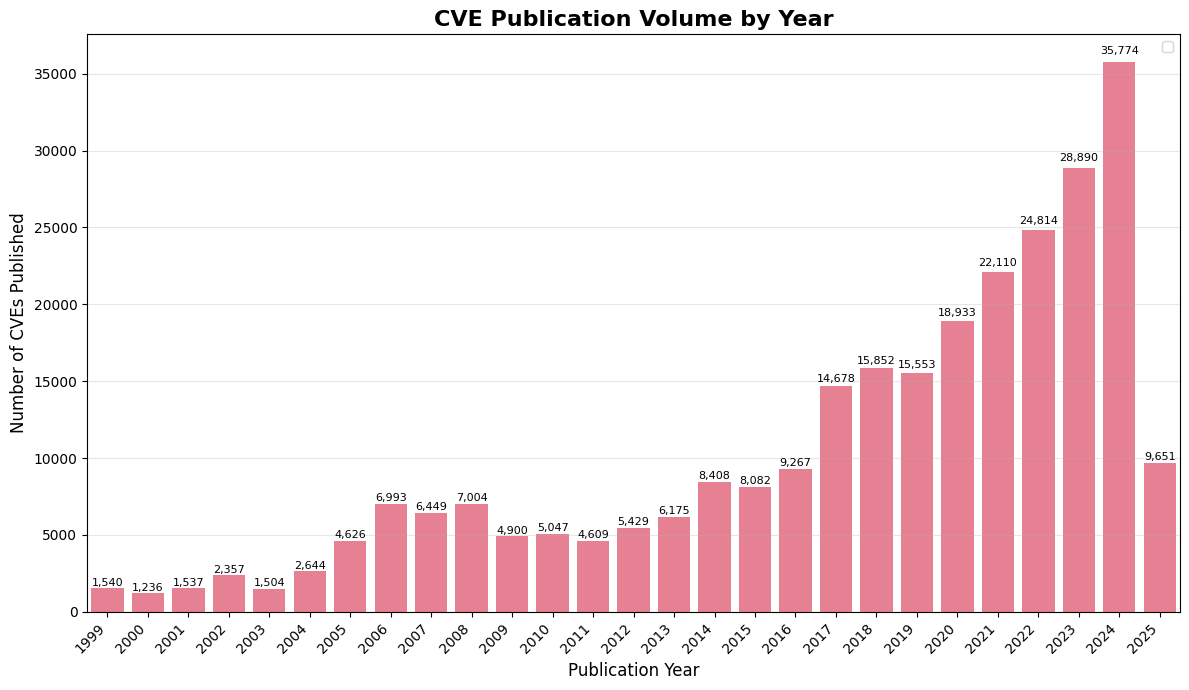


📊 Years with largest increases:
  2024: +6,884 CVEs (+23.8%)
  2017: +5,411 CVEs (+58.4%)
  2023: +4,076 CVEs (+16.4%)


In [63]:
# Calculate CVE counts by year for analysis
print("📊 Analyzing CVE publication volume by year...")
cve_counts_by_year = df['year'].value_counts().sort_index()

# Display summary statistics
print(f"\n📈 CVE Volume Statistics:")
print(f"  Total years: {len(cve_counts_by_year)}")
print(f"  Average CVEs per year: {cve_counts_by_year.mean():.0f}")
print(f"  Peak year: {cve_counts_by_year.idxmax()} ({cve_counts_by_year.max():,} CVEs)")
print(f"  Low year: {cve_counts_by_year.idxmin()} ({cve_counts_by_year.min():,} CVEs)")

# Create an enhanced bar chart of CVE volume per year
plt.figure(figsize=(12, 7))

# Create the count plot with better styling
ax = sns.countplot(data=df, x='year')

# Enhance the plot formatting
plt.title('CVE Publication Volume by Year', fontsize=16, fontweight='bold')
plt.xlabel('Publication Year', fontsize=12)
plt.ylabel('Number of CVEs Published', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars for clarity
for i, (year, count) in enumerate(cve_counts_by_year.items()):
    ax.text(i, count + (count * 0.01), f'{count:,}', 
            ha='center', va='bottom', fontsize=8)

# Add a trend line to show growth pattern
years = list(cve_counts_by_year.index)
counts = list(cve_counts_by_year.values)

plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)  # Add horizontal grid for easier reading
plt.show()

# Identify years with dramatic changes
yearly_changes = cve_counts_by_year.diff()
print(f"\n📊 Years with largest increases:")
top_increases = yearly_changes.nlargest(3)
for year, increase in top_increases.items():
    if not np.isnan(increase):
        print(f"  {year}: +{increase:,.0f} CVEs ({(increase/cve_counts_by_year[year-1]*100):+.1f}%)")

# Show years with low CVE counts (potential data quality issues)
low_threshold = 1000  # Adjust based on your data
low_volume_years = cve_counts_by_year[cve_counts_by_year < low_threshold]
if len(low_volume_years) > 0:
    print(f"\n⚠️  Years with low CVE volume (<{low_threshold:,}):")
    for year, count in low_volume_years.items():
        print(f"  {year}: {count:,} CVEs")

## 8. Data Filtering - Focus on Modern Era

### Rationale for 2016+ Filter
Based on our temporal analysis, we filter to 2016+ because:
- **Data Quality**: Earlier years show inconsistent reporting and missing values
- **CVSS Evolution**: CVSS v3.0 was released in 2015, with wider adoption from 2016
- **Threat Landscape**: Modern cyber threats are more relevant for current predictions
- **Volume Adequacy**: Post-2016 data provides sufficient volume for machine learning


In [64]:
# Filter dataset to focus on modern vulnerabilities (2016 onwards)
print("🔄 Filtering dataset to 2016 onwards...")
original_count = len(df)
df = df[df['year'] > 2015].copy()  # Keep only CVEs from 2016 onwards
filtered_count = len(df)

print(f"📊 Year-based filtering results:")
print(f"  Original records: {original_count:,}")
print(f"  After 2016+ filter: {filtered_count:,}")
print(f"  Records removed: {original_count - filtered_count:,}")
print(f"  Data retention: {(filtered_count/original_count)*100:.1f}%")
print(f"  New year range: {df['year'].min()} to {df['year'].max()}")

print("\n✅ Year filtering completed successfully!")

🔄 Filtering dataset to 2016 onwards...
📊 Year-based filtering results:
  Original records: 274,062
  After 2016+ filter: 195,522
  Records removed: 78,540
  Data retention: 71.3%
  New year range: 2016 to 2025

✅ Year filtering completed successfully!


In [65]:
# Display final dataset dimensions after all filtering
print("📊 Final Dataset Dimensions:")
print(f"  Rows (CVE records): {df.shape[0]:,}")
print(f"  Columns (features): {df.shape[1]:,}")

# Show the shape tuple for reference
df.shape

📊 Final Dataset Dimensions:
  Rows (CVE records): 195,522
  Columns (features): 21


(195522, 21)

In [66]:
# Re-analyze missing values after year filtering
print("🔍 Post-filtering Missing Value Analysis...")
null_counts_by_year_filtered = df.groupby('year', group_keys=False).apply(
    lambda x: x.isnull().sum(), 
    include_groups=False
)

print(f"📊 Missing values in filtered dataset ({df['year'].min()}-{df['year'].max()}):")
total_missing_filtered = null_counts_by_year_filtered.sum().sum()
print(f"  Total missing values: {total_missing_filtered:,}")

# Show the filtered null counts matrix
null_counts_by_year_filtered

🔍 Post-filtering Missing Value Analysis...
📊 Missing values in filtered dataset (2016-2025):
  Total missing values: 1,290


,id,baseScoreAv,exploitScoreAv,impactScoreAv,baseScoreMax,exploitScoreMax,impactScoreMax,version,baseSeverity,attackVector,attackComplexity,privilegesRequired,scope,confidentialityImpact,integrityImpact,availabilityImpact,numScores,agreement,userInteraction,target
year,,,,,,,,,,,,,,,,,,,,
2016,0,0,0,0,0,0,0,0,205,205,205,205,205,0,0,0,0,0,205,0
2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022,0,0,0,0,0,0,0,0,10,10,10,10,10,0,0,0,0,0,10,0
2023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
# Analyze data quality for the most recent year (potential data completeness issues)
current_max_year = df['year'].max()
print(f"🔍 Analyzing data completeness for year {current_max_year}...")

# Check numScores distribution for the latest year
latest_year_data = df[df['year'] == current_max_year]
print(f"📊 Records in {current_max_year}: {len(latest_year_data):,}")

if len(latest_year_data) > 0:
    print(f"\n📊 numScores distribution for {current_max_year}:")
    numscores_dist = latest_year_data['numScores'].value_counts().sort_index()
    for score, count in numscores_dist.items():
        percentage = (count / len(latest_year_data)) * 100
        print(f"  {score} scores: {count:,} records ({percentage:.1f}%)")
    
    # Show the detailed distribution
    numscores_dist
else:
    print(f"⚠️  No data found for year {current_max_year}")

🔍 Analyzing data completeness for year 2025...
📊 Records in 2025: 9,651

📊 numScores distribution for 2025:
  1 scores: 8,235 records (85.3%)
  2 scores: 1,414 records (14.7%)
  3 scores: 2 records (0.0%)


### 📊 Key Insights from EDA

### Data Quality and Structure
* **Dataset Successfully Loaded**: Raw vulnerability dataset processed with comprehensive data profiling
* **Target Variable Created**: Binary classification target based on CISA Known Exploited Vulnerabilities catalog
* **Feature Landscape**: Mixture of numerical scores (CVSS metrics) and categorical features (attack vectors, impact levels)

### Temporal Patterns
* **CVE Volume Growth**: Significant increase in vulnerability disclosures post-2016, reflecting:
  - Improved security research and disclosure practices
  - Greater awareness of cybersecurity threats
  - Evolution of vulnerability discovery tools and methodologies
* **Data Quality Evolution**: Earlier years (pre-2016) showed inconsistent data collection and higher missing value rates
* **Modern Focus**: 2016+ filter ensures we work with high-quality, consistent data using modern CVSS scoring

### Class Imbalance Challenge
* **Severe Imbalance**: Only ~0.6% of CVEs are known to be exploited in the wild
* **Real-world Reflection**: This imbalance accurately reflects the cybersecurity reality where most vulnerabilities are never exploited
* **Modeling Implications**: Will require specialized techniques to handle class imbalance (SMOTE, class weighting, threshold tuning)

### Missing Value Patterns
* **Temporal Correlation**: Missing values concentrated in earlier years and specific features
* **Feature-Specific Issues**: Some CVSS components show systematic missing patterns
* **Preprocessing Needs**: Identified candidates for imputation strategies in next notebook

### Data Preparation Success
* **Clean Foundation**: Filtered dataset ready for preprocessing with clear target definition
* **Sufficient Volume**: Post-filtering dataset maintains adequate size for machine learning
* **Quality Assurance**: Systematic EDA approach ensures robust downstream modeling


## 9. Data Export for Next Phase

Saving the cleaned and filtered dataset for the preprocessing phase. This ensures reproducibility and allows the next notebook to start with our processed data.


In [69]:
# Save the processed dataset for the next notebook
output_path = '../../data/processed_vulnerabilities.csv'
print(f"💾 Saving processed dataset to: {output_path}")

# Create output directory if it doesn't exist
import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Save the processed dataset
df.to_csv(output_path, index=False)

# Verify the save operation
saved_size = os.path.getsize(output_path) / 1024**2  # Size in MB
print(f"✅ Dataset saved successfully!")
print(f"📊 Final dataset summary:")
print(f"  Records: {len(df):,}")
print(f"  Features: {len(df.columns):,}")
print(f"  File size: {saved_size:.2f} MB")
print(f"  Exploited CVEs: {df['target'].sum():,} ({(df['target'].mean()*100):.2f}%)")
print(f"  Year range: {df['year'].min()}-{df['year'].max()}")

print(f"\n🎯 Next Steps:")
print(f"  1. Open notebook: 1_Data_Preprocessing.ipynb")
print(f"  2. Load data from: {output_path}")
print(f"  3. Continue with feature engineering and preprocessing")

print(f"\n✨ EDA Phase Complete! ✨")


💾 Saving processed dataset to: ../../data/processed_vulnerabilities.csv
✅ Dataset saved successfully!
📊 Final dataset summary:
  Records: 195,522
  Features: 21
  File size: 20.11 MB
  Exploited CVEs: 1,149 (0.59%)
  Year range: 2016-2025

🎯 Next Steps:
  1. Open notebook: 1_Data_Preprocessing.ipynb
  2. Load data from: ../../data/processed_vulnerabilities.csv
  3. Continue with feature engineering and preprocessing

✨ EDA Phase Complete! ✨
